## Example with CNN-LSTM on live BTC close price using the full data

In [28]:
import subprocess
import sys
import warnings
import os
from IPython.display import display, HTML
os.environ["TZ"] = "UTC"
warnings.filterwarnings("ignore")

USE_COLAB = False
if USE_COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    work_dir = '/content/drive/MyDrive/Colab Notebooks/sats4u/'
    secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'    
else:
    work_dir = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/sats4u/'
    secret_data_folder = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/crypto_project/crypto_data/'
    
if 'darwin' in sys.platform:
    print('Running \'caffeinate\' on MacOSX to prevent the system from sleeping')
    subprocess.Popen('caffeinate')

os.chdir(work_dir)
dir_to_save = '/Users/gabrieletocci/Documents/projects/CODE/data_sats4u/'

Running 'caffeinate' on MacOSX to prevent the system from sleeping


In [29]:
! pip install -r requirements.txt

In [30]:
import json
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b
import re

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)


## Load Asset Details, Binance client data and Download 15m candles from Binance

In [31]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details, data_folder,verbose=False)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)

In [32]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder,verbose = False)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

In [33]:
crypto.binance_client.get_account()

{'makerCommission': 10,
 'takerCommission': 10,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': True,
 'canDeposit': True,
 'updateTime': 1651961431781,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BTC', 'free': '0.00224170', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNB', 'free': '0.00000664', 'locked': '0.00000000'},
  {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '107.65342381', 'locke

### Generate Candles and build features from technical analysis

In [34]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts(verbose=True)
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [35]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [36]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

816

,Close,Pred Close
Date,,
2022-05-13 19:30:00,30063.12,30079.692479
2022-05-13 19:45:00,30084.11,30065.597934
2022-05-13 20:00:00,29924.91,30091.780531
2022-05-13 20:15:00,30030.99,30086.612095
2022-05-13 20:30:00,29974.96,30121.681522
...,...,...
2022-07-04 08:00:00,19133.03,19401.500504
2022-07-04 08:15:00,19152.09,19390.931232
2022-07-04 08:30:00,19163.27,19385.834807


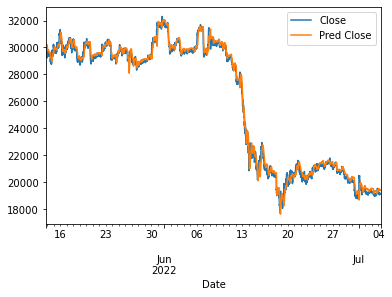

In [37]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period =  +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

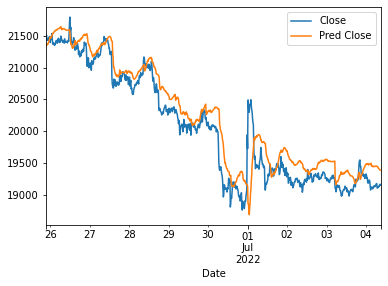

In [38]:
df_preds_true.iloc[-new_time_steps:].dropna().plot()


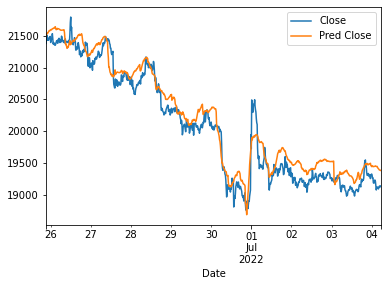

In [39]:
df_preds_shifted_true = tu.merge_true_preds(can_btc.candles, preds, period=-15+1)
df_preds_shifted_true.iloc[-new_time_steps:].dropna().plot()


Initial time 2022-06-25 21:30:00
Final time 2022-07-04 09:00:00
Fee: 0.025
----------------------
Buy      589 ( 331 ok 258 ko )
Avg PCT gain: 1.0021107585758329
Avg PCT loss: 0.9980780587557191
Wins  PCT   0.5619694397283531
Avg PCT Gain.    1.0021107585758329
No-op    0
Wallet   3405.815000000016
Drawback -352.0772499999979
Kelly Fraction    0.12570160453125012
Total earned 3405.815000000016


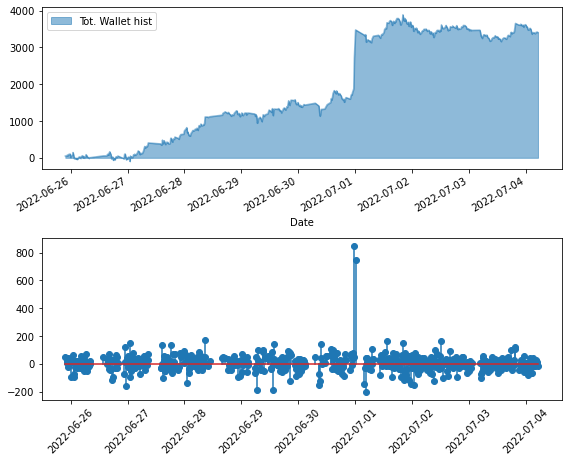

In [40]:
wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.iloc[-new_time_steps:].dropna(), step_back=+ 15,
                                                    long_short = "long", fee=0.025, cutoff_long = 10. ,cutoff_short = 10.0)
s2b.show_backtest_results(wallet,wallet_hist_df)


In [41]:
def tryexceptwait(func):
  def inner(*args,**kwargs):
        try:
          return func(*args, **kwargs)
        except:
          time.sleep(61)
          return func(*args,**kwargs)
  return inner

@tryexceptwait
def getminutedata(binance_client, ticker,interval, look_back):

  frame = pd.DataFrame(binance_client.get_historical_klines(ticker,interval, look_back + "min ago UTC"))
  frame = frame.iloc[:,:6]
  frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
  frame = frame.set_index("Time")
  frame.index = pd.to_datetime(frame.index,unit = "ms")
  frame = frame.astype(float)
  return frame

def print_time_status_and_sleep(prev_close_date,delta_date,dt_unit,sleep=True):

  elapsed_minutes = (pd.Timestamp(datetime.now()) -
                     prev_close_date).seconds/dt_unit
  time_condition = 1. < delta_date.seconds/dt_unit - elapsed_minutes < + 1.
  min_till_close = (delta_date.seconds/dt_unit - elapsed_minutes)
  print(f'Current Time: {pd.Timestamp(datetime.now())}')
  print(f'Minutes till Next Close: {min_till_close}')
  if sleep:
    print(f"Sleep for {min_till_close} mins.")
    time.sleep(min_till_close*dt_unit + 10)
    print(f"finished to sleep at {pd.Timestamp(datetime.now())}")


non_decimal = re.compile(r'[^\d.]+')
n_klines = crypto.kline_size
n_klines = non_decimal.sub('',n_klines)

#example: 
# a='123.f.'
# non_decimal.sub('', a )
# a='123'


In [42]:
crypto_test.binance_client.get_account()

{'makerCommission': 0,
 'takerCommission': 0,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': False,
 'canDeposit': False,
 'updateTime': 1656923478409,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BNB',
   'free': '1000.00000000',
   'locked': '0.00000000'},
  {'asset': 'BTC', 'free': '1.02300000', 'locked': '0.00000000'},
  {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'},
  {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '9557.57239734', 'locked': '0.00000000'},
  {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}],
 'permissions': ['SPOT']}

In [43]:
# print(
#     f'Current limit is {buyprice*(1+avg_change)} or close position in {str(time_until_close)}')
# print(
#     f'Current stop is {buyprice*(1-avg_change)} or close position in {str(time_until_close)}')

investment = 1000.
conservative_kelly = kelly_frac*.5
portfolio = investment
open_position = False
avg_change = 0.004
fee = 0.025
step_back = 15
cutoff_long = 10.

verbose = True

total_wallet_history = []
single_wallet_history = []
time_history = []
fill_order_history = []
time_fill_order_history = []
close_order_history = []

wallet = 0.
buys_cnt = 0
buys_cnt_win = 0
buys_cnt_losses = 0
drawback = 0
old_profit_negative = False
old_profits = 0
mean_pct_gain = 0
mean_pct_loss = 0

last_dates = getminutedata(
    crypto.binance_client, tickers[0], crypto.kline_size, '30').index
delta_date = last_dates[-1]-last_dates[-2]
prev_close_date = last_dates[-1]
buffer_delta = 0.1*delta_date

while True:
 
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep = True)
    ldata_df_new = crypto.load_cryptos(tickers,save = False)
    can_btc = fb.Candles(ldata_df_new,"Bitcoin")
    can_btc.buildfeatures()
    ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = crypto.kline_size,
                    lownorm = 0.2, upnorm= 0.8)

    ts_btc.candles2ts(verbose = False)
    ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
    ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
    initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
    loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
    loaded_model.sats2model()
    loaded_model.load_model(model_name)
    loaded_model.sats2pred(predict_on_test = False)
    loaded_model.load_scaler(model_name + '/scaler.sav')
    preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)
    df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
    df_preds_true_shifted = df_preds_true.copy()
    df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(step_back,delta_date)

    prev_true_close = df_preds_true_shifted.iloc[-2,0]
    pred_close = df_preds_true_shifted.iloc[-1,1]

    prev_close_date = ldata_df_new["Date"].iloc[-1]
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep=False)

    if open_position == False :

        if prev_true_close*(1+fee/cutoff_long) < pred_close:

            dff = getminutedata(crypto.binance_client, tickers[0],'1m','120')
            buy_quantity = round(portfolio*conservative_kelly / float(dff['Close'].iloc[-1]))
            buy_quantity = 0.001
            order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                        side='BUY',
                                                        type='MARKET',
                                                        quantity= buy_quantity)
                                                        
            order_time = pd.Timestamp(datetime.now())
            est_close_time = df_preds_true_shifted.index[-1]
            open_position = True
            filled_open_price = float(order['fills'][0]['price'])

            print('-----------------------------------')
            print(f'Order filled at {str(order_time)}')
            print(f'Order will be closed around {str(est_close_time)}')
            print(f'Filled open price: {filled_open_price}')
            print(f'Previous close price: {prev_true_close}')
            print(f'Predicted close price: {pred_close}')

            while open_position :

                time.sleep(60)
                dff = getminutedata(crypto.binance_client, tickers[0],'1m','2')
                current_price = dff["Close"].iloc[-1]
                current_time = pd.Timestamp(datetime.now())
                time_until_close = (est_close_time - current_time - buffer_delta )

                if verbose:
                    print('--------------------------------')
                    print(f'Current price: {current_price}')
                    print(f'Current time: {current_time}')
                    print(f'Time until close of position: {time_until_close} mins.')
                    print(f'Position will be closed at {time_until_close + current_time}')
                
                if (time_until_close.seconds/crypto.dt) < 1 :

                    order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                                side='SELL',
                                                                type='MARKET',
                                                                quantity= buy_quantity)  
                    open_position = False
                    filled_close_price = float(order['fills'][0]['price'])
                    order_close_time = pd.Timestamp(datetime.now())
                    profit = filled_close_price - filled_open_price
                    wallet += profit
                    total_wallet_history.append(wallet)
                    single_wallet_history.append(profit)
                    time_history.append(order_close_time)
                    buys_cnt += 1

                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Filled open price: {filled_open_price}')
                    print(f'Filled close price: {filled_close_price}')
                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Profit: {profit}')
                    prev_close_date = getminutedata(crypto.binance_client, tickers[0], crypto.kline_size, n_klines).index[-1]
                
                    if profit > 0:
                        buys_cnt_win += 1
                        old_profit_negative = False
                        mean_pct_gain += filled_close_price / filled_open_price
                    else:
                        buys_cnt_losses += 1
                        mean_pct_loss += filled_close_price / filled_open_price
                        if old_profit_negative:
                            old_profits += profit
                        else:
                            old_profits = profit
                        if old_profits < drawback:
                            drawback = old_profits
                        old_profit_negative = True                    
        else:
            old_profit_negative = False
            old_profits = 0
            prev_close_date = getminutedata(
                crypto.binance_client, tickers[0], crypto.kline_size, n_klines).index[-1]
            print(f'Order not filled Sleep for {crypto.kline_size}')
            
        wallet_hist_df = pd.DataFrame(
            np.array([total_wallet_history, single_wallet_history]).T,
            index=pd.Series(time_history, name="Date"),
            columns=["Tot. Wallet hist", "Single Wallet hist"],
        )
        display(wallet_hist_df)
        wallet_hist_df.to_csv(dir_to_save + "/live_wallet_history.csv")


Current Time: 2022-07-04 09:02:39.286398
Minutes till Next Close: 12.35
Sleep for 12.35 mins.
finished to sleep at 2022-07-04 09:15:10.279607
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 09:15:37.208933
Minutes till Next Close: 14.383333333333333
-----------------------------------
Order filled at 2022-07-04 09:15:38.718956
Order will be closed around 2022-07-04 09:30:00
Filled open price: 19161.35
Previous close price: 19129.76
Predicted close price: 19416.066394489997
--------------------------------
Current price: 19171.27
Current time: 2022-07-04 09:16:39.446811
Time until close of position: 0 days 00:11:50.553189 mins.
Position will be closed at 2022-07-04 09:28:30
--------------------------------
Current price: 19179.88
Current time: 2022-07-04 09:17:40.026136
Time until close of position: 0 days 00:10:49.973864 mins.
Position will be close

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72


Current Time: 2022-07-04 09:27:48.744522
Minutes till Next Close: 2.1999999999999993
Sleep for 2.1999999999999993 mins.
finished to sleep at 2022-07-04 09:30:10.754217
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 09:30:42.359991
Minutes till Next Close: 14.3
-----------------------------------
Order filled at 2022-07-04 09:30:43.789131
Order will be closed around 2022-07-04 09:45:00
Filled open price: 19212.29
Previous close price: 19137.19
Predicted close price: 19387.487790432566
--------------------------------
Current price: 19215.42
Current time: 2022-07-04 09:31:44.262769
Time until close of position: 0 days 00:11:45.737231 mins.
Position will be closed at 2022-07-04 09:43:30
--------------------------------
Current price: 19259.99
Current time: 2022-07-04 09:32:44.836927
Time until close of position: 0 days 00:10:45.163073 mins.
Position w

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71


Current Time: 2022-07-04 09:42:52.329202
Minutes till Next Close: 2.133333333333333
Sleep for 2.133333333333333 mins.
finished to sleep at 2022-07-04 09:45:10.329752
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 09:45:38.013787
Minutes till Next Close: 14.366666666666667
-----------------------------------
Order filled at 2022-07-04 09:45:39.427363
Order will be closed around 2022-07-04 10:00:00
Filled open price: 19334.76
Previous close price: 19163.24
Predicted close price: 19369.841787171357
--------------------------------
Current price: 19353.25
Current time: 2022-07-04 09:46:39.930947
Time until close of position: 0 days 00:11:50.069053 mins.
Position will be closed at 2022-07-04 09:58:30
--------------------------------
Current price: 19372.71
Current time: 2022-07-04 09:47:40.543597
Time until close of position: 0 days 00:10:49.456403 mins

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13


Current Time: 2022-07-04 09:57:48.019264
Minutes till Next Close: 2.1999999999999993
Sleep for 2.1999999999999993 mins.
finished to sleep at 2022-07-04 10:00:10.020825
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 10:00:36.624641
Minutes till Next Close: 14.4
-----------------------------------
Order filled at 2022-07-04 10:00:38.653738
Order will be closed around 2022-07-04 10:15:00
Filled open price: 19391.98
Previous close price: 19168.02
Predicted close price: 19282.698484477394
--------------------------------
Current price: 19412.88
Current time: 2022-07-04 10:01:39.365142
Time until close of position: 0 days 00:11:50.634858 mins.
Position will be closed at 2022-07-04 10:13:30
--------------------------------
Current price: 19411.75
Current time: 2022-07-04 10:02:39.927821
Time until close of position: 0 days 00:10:50.072179 mins.
Position w

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00


Current Time: 2022-07-04 10:12:48.603694
Minutes till Next Close: 2.1999999999999993
Sleep for 2.1999999999999993 mins.
finished to sleep at 2022-07-04 10:15:10.605571
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 10:15:45.056825
Minutes till Next Close: 14.25
-----------------------------------
Order filled at 2022-07-04 10:15:46.279922
Order will be closed around 2022-07-04 10:30:00
Filled open price: 19444.12
Previous close price: 19173.89
Predicted close price: 19265.919888165587
--------------------------------
Current price: 19466.96
Current time: 2022-07-04 10:16:47.040408
Time until close of position: 0 days 00:11:42.959592 mins.
Position will be closed at 2022-07-04 10:28:30
--------------------------------
Current price: 19457.47
Current time: 2022-07-04 10:17:47.859936
Time until close of position: 0 days 00:10:42.140064 mins.
Position 

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72


Current Time: 2022-07-04 10:27:56.530702
Minutes till Next Close: 2.0666666666666664
Sleep for 2.0666666666666664 mins.
finished to sleep at 2022-07-04 10:30:10.583338
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 10:30:38.276082
Minutes till Next Close: 14.366666666666667
-----------------------------------
Order filled at 2022-07-04 10:30:39.553128
Order will be closed around 2022-07-04 10:45:00
Filled open price: 19491.33
Previous close price: 19101.42
Predicted close price: 19245.3377942115
--------------------------------
Current price: 19464.19
Current time: 2022-07-04 10:31:40.065963
Time until close of position: 0 days 00:11:49.934037 mins.
Position will be closed at 2022-07-04 10:43:30
--------------------------------
Current price: 19461.08
Current time: 2022-07-04 10:32:40.784658
Time until close of position: 0 days 00:10:49.215342 mins

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41


Current Time: 2022-07-04 10:42:48.372175
Minutes till Next Close: 2.1999999999999993
Sleep for 2.1999999999999993 mins.
finished to sleep at 2022-07-04 10:45:10.377999
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 10:45:38.588126
Minutes till Next Close: 14.366666666666667
-----------------------------------
Order filled at 2022-07-04 10:45:39.979867
Order will be closed around 2022-07-04 11:00:00
Filled open price: 19503.31
Previous close price: 19104.0
Predicted close price: 19257.25236513912
--------------------------------
Current price: 19487.52
Current time: 2022-07-04 10:46:40.587850
Time until close of position: 0 days 00:11:49.412150 mins.
Position will be closed at 2022-07-04 10:58:30
--------------------------------
Current price: 19488.93
Current time: 2022-07-04 10:47:41.384966
Time until close of position: 0 days 00:10:48.615034 mins

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41


Current Time: 2022-07-04 10:57:48.934990
Minutes till Next Close: 2.1999999999999993
Sleep for 2.1999999999999993 mins.
finished to sleep at 2022-07-04 11:00:10.936116
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 11:00:48.409150
Minutes till Next Close: 14.2
-----------------------------------
Order filled at 2022-07-04 11:00:49.700454
Order will be closed around 2022-07-04 11:15:00
Filled open price: 19478.51
Previous close price: 19114.47
Predicted close price: 19279.543087121838
--------------------------------
Current price: 19486.21
Current time: 2022-07-04 11:01:50.324017
Time until close of position: 0 days 00:11:39.675983 mins.
Position will be closed at 2022-07-04 11:13:30
--------------------------------
Current price: 19502.63
Current time: 2022-07-04 11:02:50.927056
Time until close of position: 0 days 00:10:39.072944 mins.
Position w

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27


Current Time: 2022-07-04 11:12:59.131512
Minutes till Next Close: 2.0166666666666675
Sleep for 2.0166666666666675 mins.
finished to sleep at 2022-07-04 11:15:10.136171
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 11:15:37.846938
Minutes till Next Close: 14.383333333333333
-----------------------------------
Order filled at 2022-07-04 11:15:39.979204
Order will be closed around 2022-07-04 11:30:00
Filled open price: 19530.28
Previous close price: 19129.93
Predicted close price: 19298.13832817673
--------------------------------
Current price: 19510.38
Current time: 2022-07-04 11:16:40.654055
Time until close of position: 0 days 00:11:49.345945 mins.
Position will be closed at 2022-07-04 11:28:30
--------------------------------
Current price: 19536.85
Current time: 2022-07-04 11:17:41.222871
Time until close of position: 0 days 00:10:48.777129 min

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 11:27:47.936016
Minutes till Next Close: 2.216666666666667
Sleep for 2.216666666666667 mins.
finished to sleep at 2022-07-04 11:30:10.939549
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 11:30:37.091862
Minutes till Next Close: 14.383333333333333
-----------------------------------
Order filled at 2022-07-04 11:30:38.717124
Order will be closed around 2022-07-04 11:45:00
Filled open price: 19536.63
Previous close price: 19120.6
Predicted close price: 19305.72568405866
--------------------------------
Current price: 19567.42
Current time: 2022-07-04 11:31:39.432227
Time until close of position: 0 days 00:11:50.567773 mins.
Position will be closed at 2022-07-04 11:43:30
--------------------------------
Current price: 19611.65
Current time: 2022-07-04 11:32:39.966612
Time until close of position: 0 days 00:10:50.033388 mins.


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 11:42:48.926349
Minutes till Next Close: 2.1999999999999993
Sleep for 2.1999999999999993 mins.
finished to sleep at 2022-07-04 11:45:10.930079
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 11:45:49.230053
Minutes till Next Close: 14.183333333333334
-----------------------------------
Order filled at 2022-07-04 11:45:50.625348
Order will be closed around 2022-07-04 12:00:00
Filled open price: 19623.82
Previous close price: 19133.03
Predicted close price: 19291.408559542888
--------------------------------
Current price: 19593.74
Current time: 2022-07-04 11:46:51.172040
Time until close of position: 0 days 00:11:38.827960 mins.
Position will be closed at 2022-07-04 11:58:30
--------------------------------
Current price: 19609.89
Current time: 2022-07-04 11:47:51.703958
Time until close of position: 0 days 00:10:38.296042 mi

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 11:58:01.870459
Minutes till Next Close: 1.9833333333333325
Sleep for 1.9833333333333325 mins.
finished to sleep at 2022-07-04 12:00:10.879548
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 12:00:40.427898
Minutes till Next Close: 14.333333333333334
-----------------------------------
Order filled at 2022-07-04 12:00:41.848395
Order will be closed around 2022-07-04 12:15:00
Filled open price: 19826.73
Previous close price: 19152.09
Predicted close price: 19216.2420192182
--------------------------------
Current price: 19774.98
Current time: 2022-07-04 12:01:42.436231
Time until close of position: 0 days 00:11:47.563769 mins.
Position will be closed at 2022-07-04 12:13:30
--------------------------------
Current price: 19864.9
Current time: 2022-07-04 12:02:43.804913
Time until close of position: 0 days 00:10:46.195087 mins.

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 12:12:51.461604
Minutes till Next Close: 2.1500000000000004
Sleep for 2.1500000000000004 mins.
finished to sleep at 2022-07-04 12:15:10.467778
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 12:15:38.663767
Minutes till Next Close: 14.366666666666667
Order not filled Sleep for 15m


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 12:15:39.208885
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-04 12:30:10.235689
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 12:30:39.382630
Minutes till Next Close: 14.35
-----------------------------------
Order filled at 2022-07-04 12:30:40.766390
Order will be closed around 2022-07-04 12:45:00
Filled open price: 19697.81
Previous close price: 19147.25
Predicted close price: 19230.546050798886
--------------------------------
Current price: 19710.7
Current time: 2022-07-04 12:31:41.521185
Time until close of position: 0 days 00:11:48.478815 mins.
Position will be closed at 2022-07-04 12:43:30
--------------------------------
Current price: 19701.29
Current time: 2022-07-04 12:32:42.723015
Time until close of position: 0 days 00:10:47.276985 mins.
Position will be closed at 2022-07-0

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 12:42:51.017276
Minutes till Next Close: 2.1500000000000004
Sleep for 2.1500000000000004 mins.
finished to sleep at 2022-07-04 12:45:10.020468
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 12:45:54.090367
Minutes till Next Close: 14.1
-----------------------------------
Order filled at 2022-07-04 12:45:55.520066
Order will be closed around 2022-07-04 13:00:00
Filled open price: 19655.37
Previous close price: 19156.93
Predicted close price: 19259.85131275355
--------------------------------
Current price: 19660.65
Current time: 2022-07-04 12:46:57.718552
Time until close of position: 0 days 00:11:32.281448 mins.
Position will be closed at 2022-07-04 12:58:30
--------------------------------
Current price: 19697.71
Current time: 2022-07-04 12:47:58.980201
Time until close of position: 0 days 00:10:31.019799 mins.
Position wi

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 12:58:08.929071
Minutes till Next Close: 1.8666666666666671
Sleep for 1.8666666666666671 mins.
finished to sleep at 2022-07-04 13:00:10.935288
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 13:00:39.181948
Minutes till Next Close: 14.35
-----------------------------------
Order filled at 2022-07-04 13:00:40.452949
Order will be closed around 2022-07-04 13:15:00
Filled open price: 19717.37
Previous close price: 19235.95
Predicted close price: 19322.900341656798
--------------------------------
Current price: 19716.41
Current time: 2022-07-04 13:01:41.143850
Time until close of position: 0 days 00:11:48.856150 mins.
Position will be closed at 2022-07-04 13:13:30
--------------------------------
Current price: 19707.15
Current time: 2022-07-04 13:02:42.414221
Time until close of position: 0 days 00:10:47.585779 mins.
Position 

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 13:12:51.718775
Minutes till Next Close: 2.1500000000000004
Sleep for 2.1500000000000004 mins.
finished to sleep at 2022-07-04 13:15:10.731496
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 13:15:39.978498
Minutes till Next Close: 14.35
-----------------------------------
Order filled at 2022-07-04 13:15:42.810735
Order will be closed around 2022-07-04 13:30:00
Filled open price: 19743.86
Previous close price: 19259.05
Predicted close price: 19365.612769138806
--------------------------------
Current price: 19730.66
Current time: 2022-07-04 13:16:43.575862
Time until close of position: 0 days 00:11:46.424138 mins.
Position will be closed at 2022-07-04 13:28:30
--------------------------------
Current price: 19725.08
Current time: 2022-07-04 13:17:44.101556
Time until close of position: 0 days 00:10:45.898444 mins.
Position 

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 13:27:52.495577
Minutes till Next Close: 2.133333333333333
Sleep for 2.133333333333333 mins.
finished to sleep at 2022-07-04 13:30:10.504591
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 13:30:38.219385
Minutes till Next Close: 14.366666666666667
-----------------------------------
Order filled at 2022-07-04 13:30:39.482700
Order will be closed around 2022-07-04 13:45:00
Filled open price: 19694.03
Previous close price: 19367.05
Predicted close price: 19433.368708205217
--------------------------------
Current price: 19677.68
Current time: 2022-07-04 13:31:40.172289
Time until close of position: 0 days 00:11:49.827711 mins.
Position will be closed at 2022-07-04 13:43:30
--------------------------------
Current price: 19667.53
Current time: 2022-07-04 13:32:40.988758
Time until close of position: 0 days 00:10:49.011242 mins

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 13:42:49.220486
Minutes till Next Close: 2.1833333333333336
Sleep for 2.1833333333333336 mins.
finished to sleep at 2022-07-04 13:45:10.225886
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 13:45:54.809664
Minutes till Next Close: 14.1
Order not filled Sleep for 15m


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 13:45:55.332000
Minutes till Next Close: 14.083333333333334
Sleep for 14.083333333333334 mins.
finished to sleep at 2022-07-04 14:00:10.335918
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 14:00:39.435159
Minutes till Next Close: 14.35
Order not filled Sleep for 15m


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 14:00:39.991105
Minutes till Next Close: 14.35
Sleep for 14.35 mins.
finished to sleep at 2022-07-04 14:15:10.997961
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 14:15:41.840054
Minutes till Next Close: 14.316666666666666
Order not filled Sleep for 15m


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 14:15:43.053547
Minutes till Next Close: 14.283333333333333
Sleep for 14.283333333333333 mins.
finished to sleep at 2022-07-04 14:30:10.105626
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 14:30:43.085713
Minutes till Next Close: 14.283333333333333
-----------------------------------
Order filled at 2022-07-04 14:30:44.654678
Order will be closed around 2022-07-04 14:45:00
Filled open price: 19587.01
Previous close price: 19470.65
Predicted close price: 19535.251382571452
--------------------------------
Current price: 19564.17
Current time: 2022-07-04 14:31:45.181194
Time until close of position: 0 days 00:11:44.818806 mins.
Position will be closed at 2022-07-04 14:43:30
--------------------------------
Current price: 19577.93
Current time: 2022-07-04 14:32:45.838059
Time until close of position: 0 days 00:10:44.161941 mi

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 14:42:53.641743
Minutes till Next Close: 2.116666666666667
Sleep for 2.116666666666667 mins.
finished to sleep at 2022-07-04 14:45:10.645290
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 14:45:41.922823
Minutes till Next Close: 14.316666666666666
Order not filled Sleep for 15m


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 14:45:42.411288
Minutes till Next Close: 14.3
Sleep for 14.3 mins.
finished to sleep at 2022-07-04 15:00:10.424325
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 15:00:40.841152
Minutes till Next Close: 14.333333333333334
-----------------------------------
Order filled at 2022-07-04 15:00:42.109487
Order will be closed around 2022-07-04 15:15:00
Filled open price: 19615.69
Previous close price: 19532.37
Predicted close price: 19601.69148166179
--------------------------------
Current price: 19633.27
Current time: 2022-07-04 15:01:42.618298
Time until close of position: 0 days 00:11:47.381702 mins.
Position will be closed at 2022-07-04 15:13:30
--------------------------------
Current price: 19634.83
Current time: 2022-07-04 15:02:43.145003
Time until close of position: 0 days 00:10:46.854997 mins.
Position will be closed a

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 15:12:52.387222
Minutes till Next Close: 2.133333333333333
Sleep for 2.133333333333333 mins.
finished to sleep at 2022-07-04 15:15:10.393185
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 15:16:17.797699
Minutes till Next Close: 13.716666666666667
Order not filled Sleep for 15m


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 15:16:19.045475
Minutes till Next Close: 13.683333333333334
Sleep for 13.683333333333334 mins.
finished to sleep at 2022-07-04 15:30:10.087635
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 15:30:43.333488
Minutes till Next Close: 14.283333333333333
Order not filled Sleep for 15m


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 15:30:43.826663
Minutes till Next Close: 14.283333333333333
Sleep for 14.283333333333333 mins.
finished to sleep at 2022-07-04 15:45:10.839076
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-04 15:45:46.844056
Minutes till Next Close: 14.233333333333333
Order not filled Sleep for 15m


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-04 09:27:47.877533,69.72,69.72
2022-07-04 09:42:51.788755,97.43,27.71
2022-07-04 09:57:47.487172,153.56,56.13
2022-07-04 10:12:48.070217,200.56,47.00
2022-07-04 10:27:55.123294,237.28,36.72
2022-07-04 10:42:47.576273,259.69,22.41
2022-07-04 10:57:48.449482,235.28,-24.41
2022-07-04 11:12:58.596667,255.55,20.27
2022-07-04 11:27:47.396119,200.49,-55.06


Current Time: 2022-07-04 15:45:47.977058
Minutes till Next Close: 14.216666666666667
Sleep for 14.216666666666667 mins.


In [ ]:
wall_hist = pd.read_csv(dir_to_save + "/live_wallet_history.csv", index_col=0)
wall_hist.index = pd.to_datetime(wall_hist.index)
wall_hist


### Try with Long Short Strategy here. First write functions to make code a bit shorter

In [ ]:
def create_order_util(crypto, crypto_test, order_side, ticker, investment, kelly_frac):

    if order_side != "BUY" and order_side != "SELL":
        raise ValueError("order_side can only be BUY or SELL")

    dff = getminutedata(crypto.binance_client,ticker,"1m",120)
    buy_quantity = round(investment*kelly_frac / float(dff['Close'].iloc[-1]))
    buy_quantity = 0.001

    if crypto_test is not None:
        order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                    side=order_side,
                                                    type='MARKET',
                                                    quantity=buy_quantity)
    else:
        order = crypto.binance_client.create_order(symbol=tickers[0],
                                                        side=order_side,
                                                        type='MARKET',
                                                        quantity=buy_quantity)
    order_time = pd.Timestamp(datetime.now())
    open_position = True
    filled_open_price = float(order['fills'][0]['price'])

    return open_position, order, order_time, filled_open_price


# est_close_time = df_preds_true_shifted.index[-1]
# ticker = tickers[0]
# order_side = "SELL"
# client_test = crypto_test
# client = crypto
#open_position, order, order_time, filled_open_price = create_order_util(crypto, crypto_test, order_side, ticker, investment, kelly_frac)

def check_position_util(crypto,est_close_time,buffer_delta,verbose = False):

    time.sleep(60)
    dff = getminutedata(crypto.binance_client,ticker, '1m', '2')                
    current_price = dff["Close"].iloc[-1]
    current_time = pd.Timestamp(datetime.now())
    time_until_close = (est_close_time - current_time - buffer_delta)

    if verbose:
        print('--------------------------------')
        print(f'Current price: {current_price}')
        print(f'Current time: {current_time}')
        print(f'Time until close of position: {time_until_close} mins.')
        print(f'Position will be closed at {time_until_close + current_time}')

    return current_price, current_time, time_until_close

#current_price, current_time, time_until_close = check_open_position(crypto, est_close_time, buffer_delta, verbose = True)


def close_position_util(crypto, crypto_test, order_side, quantity_to_close):

    if order_side != "BUY" and order_side != "SELL":
        raise ValueError("order_side can only be BUY or SELL")

    if crypto_test is not None:

        order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                side = order_side,
                                                type='MARKET',
                                                quantity=quantity_to_close)
    else:
        order = crypto.binance_client.create_order(symbol=tickers[0],
                                                        side=order_side,
                                                        type='MARKET',
                                                        quantity=quantity_to_close)

    open_position = False
    filled_close_price = float(order['fills'][0]['price'])
    order_close_time = pd.Timestamp(datetime.now())
    profit = filled_close_price - filled_open_price
    wallet += profit
    buys_cnt += 1

    print(f'Position closed at {str(order_close_time)}')
    print(f'Filled open price: {filled_open_price}')
    print(f'Filled close price: {filled_close_price}')
    print(f'Position closed at {str(order_close_time)}')
    print(f'Profit: {profit}')

    if profit > 0:
        buys_cnt_win += 1
        old_profit_negative = False
        mean_pct_gain += filled_close_price / filled_open_price
    else:
        buys_cnt_losses += 1
        mean_pct_loss += filled_close_price / filled_open_price
        if old_profit_negative:
            old_profits += profit
        else:
            old_profits = profit
        if old_profits < drawback:
            drawback = old_profits
        old_profit_negative = True

    return wallet, profit, order_close_time, open_position


#wallet, profit, order_close_time, open_position = close_position_util(crypto, crypto_test, order_side, quantity_to_close)
#                    
#total_wallet_history.append(wallet)
#single_wallet_history.append(profit)
#time_history.append(order_close_time)



In [ ]:

investment = 1000.
conservative_kelly = kelly_frac*.5
portfolio = investment
open_position = False
avg_change = 0.004
fee = 0.025
step_back = 15
cutoff_long = 10.

verbose = True

total_wallet_history = []
single_wallet_history = []
time_history = []
fill_order_history = []
time_fill_order_history = []
close_order_history = []

wallet = 0.
buys_cnt = 0
buys_cnt_win = 0
buys_cnt_losses = 0
drawback = 0
old_profit_negative = False
old_profits = 0
mean_pct_gain = 0
mean_pct_loss = 0

last_dates = getminutedata(
    crypto.binance_client, tickers[0], crypto.kline_size, '30').index
delta_date = last_dates[-1]-last_dates[-2]
prev_close_date = last_dates[-1]
buffer_delta = 0.1*delta_date

while True:

    print_time_status_and_sleep(
        prev_close_date, delta_date, crypto.dt, sleep=True)
    ldata_df_new = crypto.load_cryptos(tickers, save=False)
    can_btc = fb.Candles(ldata_df_new, "Bitcoin")
    can_btc.buildfeatures()
    ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps=2000, step_back=48, candle_step_str=crypto.kline_size,
                                   lownorm=0.2, upnorm=0.8)

    ts_btc.candles2ts(verbose=False)
    ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
    ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
    initial_timestamp = pd.Timestamp(
        datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
    loaded_model = s2m.TimeSeries2Model(
        ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction=1)
    loaded_model.sats2model()
    loaded_model.load_model(model_name)
    loaded_model.sats2pred(predict_on_test=False)
    loaded_model.load_scaler(model_name + '/scaler.sav')
    preds = c2t.denorm(loaded_model.scaler,
                       can_btc.candles, loaded_model.preds)
    df_preds_true = tu.merge_true_preds(can_btc.candles, preds, period=+1)
    df_preds_true_shifted = df_preds_true.copy()
    df_preds_true_shifted.iloc[:, 0] = df_preds_true.iloc[:, 0].shift(
        step_back, delta_date)

    prev_true_close = df_preds_true_shifted.iloc[-2, 0]
    pred_close = df_preds_true_shifted.iloc[-1, 1]

    prev_close_date = ldata_df_new["Date"].iloc[-1]
    print_time_status_and_sleep(
        prev_close_date, delta_date, crypto.dt, sleep=False)

    if open_position == False:

        if prev_true_close*(1+fee/cutoff_long) > pred_close:

            dff = getminutedata(crypto.binance_client, tickers[0], '1m', '120')
            buy_quantity = round(
                portfolio*conservative_kelly / float(dff['Close'].iloc[-1]))
            buy_quantity = 0.001
            order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                            side='SELL',
                                                            type='MARKET',
                                                            quantity=buy_quantity)

            order_time = pd.Timestamp(datetime.now())
            est_close_time = df_preds_true_shifted.index[-1]
            open_position = True
            filled_open_price = float(order['fills'][0]['price'])

            print('-----------------------------------')
            print(f'Order filled at {str(order_time)}')
            print(f'Order will be closed around {str(est_close_time)}')
            print(f'Filled open price: {filled_open_price}')
            print(f'Previous close price: {prev_true_close}')
            print(f'Predicted close price: {pred_close}')

            while open_position:

                time.sleep(60)
                dff = getminutedata(crypto.binance_client,
                                    tickers[0], '1m', '2')
                current_price = dff["Close"].iloc[-1]
                current_time = pd.Timestamp(datetime.now())
                time_until_close = (
                    est_close_time - current_time - buffer_delta)

                if verbose:
                    print('--------------------------------')
                    print(f'Current price: {current_price}')
                    print(f'Current time: {current_time}')
                    print(
                        f'Time until close of position: {time_until_close} mins.')
                    print(
                        f'Position will be closed at {time_until_close + current_time}')

                if (time_until_close.seconds/crypto.dt) < 1:

                    order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                                    side='SELL',
                                                                    type='MARKET',
                                                                    quantity=buy_quantity)
                    open_position = False
                    filled_close_price = float(order['fills'][0]['price'])
                    order_close_time = pd.Timestamp(datetime.now())
                    profit = filled_close_price - filled_open_price
                    wallet += profit
                    total_wallet_history.append(wallet)
                    single_wallet_history.append(profit)
                    time_history.append(order_close_time)
                    buys_cnt += 1

                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Filled open price: {filled_open_price}')
                    print(f'Filled close price: {filled_close_price}')
                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Profit: {profit}')
                    prev_close_date = getminutedata(
                        crypto.binance_client, tickers[0], crypto.kline_size, n_klines).index[-1]

                    if profit > 0:
                        buys_cnt_win += 1
                        old_profit_negative = False
                        mean_pct_gain += filled_close_price / filled_open_price
                    else:
                        buys_cnt_losses += 1
                        mean_pct_loss += filled_close_price / filled_open_price
                        if old_profit_negative:
                            old_profits += profit
                        else:
                            old_profits = profit
                        if old_profits < drawback:
                            drawback = old_profits
                        old_profit_negative = True

        
        elif prev_true_close*(1+fee/cutoff_long) < pred_close:

            dff = getminutedata(crypto.binance_client, tickers[0], '1m', '120')
            buy_quantity = round(
                portfolio*conservative_kelly / float(dff['Close'].iloc[-1]))
            buy_quantity = 0.001
            order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                            side='BUY',
                                                            type='MARKET',
                                                            quantity=buy_quantity)

            order_time = pd.Timestamp(datetime.now())
            est_close_time = df_preds_true_shifted.index[-1]
            open_position = True
            filled_open_price = float(order['fills'][0]['price'])

            print('-----------------------------------')
            print(f'Order filled at {str(order_time)}')
            print(f'Order will be closed around {str(est_close_time)}')
            print(f'Filled open price: {filled_open_price}')
            print(f'Previous close price: {prev_true_close}')
            print(f'Predicted close price: {pred_close}')

            while open_position:

                time.sleep(60)
                dff = getminutedata(crypto.binance_client,
                                    tickers[0], '1m', '2')
                current_price = dff["Close"].iloc[-1]
                current_time = pd.Timestamp(datetime.now())
                time_until_close = (
                    est_close_time - current_time - buffer_delta)

                if verbose:
                    print('--------------------------------')
                    print(f'Current price: {current_price}')
                    print(f'Current time: {current_time}')
                    print(
                        f'Time until close of position: {time_until_close} mins.')
                    print(
                        f'Position will be closed at {time_until_close + current_time}')

                if (time_until_close.seconds/crypto.dt) < 1:

                    order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                                    side='SELL',
                                                                    type='MARKET',
                                                                    quantity=buy_quantity)
                    open_position = False
                    filled_close_price = float(order['fills'][0]['price'])
                    order_close_time = pd.Timestamp(datetime.now())
                    profit = filled_close_price - filled_open_price
                    wallet += profit
                    total_wallet_history.append(wallet)
                    single_wallet_history.append(profit)
                    time_history.append(order_close_time)
                    buys_cnt += 1

                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Filled open price: {filled_open_price}')
                    print(f'Filled close price: {filled_close_price}')
                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Profit: {profit}')
                    prev_close_date = getminutedata(
                        crypto.binance_client, tickers[0], crypto.kline_size, n_klines).index[-1]

                    if profit > 0:
                        buys_cnt_win += 1
                        old_profit_negative = False
                        mean_pct_gain += filled_close_price / filled_open_price
                    else:
                        buys_cnt_losses += 1
                        mean_pct_loss += filled_close_price / filled_open_price
                        if old_profit_negative:
                            old_profits += profit
                        else:
                            old_profits = profit
                        if old_profits < drawback:
                            drawback = old_profits
                        old_profit_negative = True
        else:
            old_profit_negative = False
            old_profits = 0
            prev_close_date = getminutedata(
                crypto.binance_client, tickers[0], crypto.kline_size, n_klines).index[-1]
            print(f'Order not filled Sleep for {crypto.kline_size}')

        wallet_hist_df = pd.DataFrame(
            np.array([total_wallet_history, single_wallet_history]).T,
            index=pd.Series(time_history, name="Date"),
            columns=["Tot. Wallet hist", "Single Wallet hist"],
        )
        display(wallet_hist_df)
        wallet_hist_df.to_csv(dir_to_save + "/live_wallet_history.csv")
